In [ ]:
# --- Kurulum
import json, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path(".").resolve()
CFG_PATH = ROOT / "configs" / "config.json"
MAP_PATH = ROOT / "configs" / "mapping_dbra24.json"
DATA_PATH = ROOT / "data" / "processed" / "dbra24_test.jsonl"

OUT = ROOT / "out"
PLOTS = OUT / "plots"
OUT.mkdir(parents=True, exist_ok=True)
PLOTS.mkdir(parents=True, exist_ok=True)

CFG = json.loads(CFG_PATH.read_text(encoding="utf-8"))
MAP = json.loads(MAP_PATH.read_text(encoding="utf-8"))

print("Config keys:", list(CFG.keys()))
print("Mapping keys:", list(MAP.keys()))


Config keys: ['version', 'api', 'geofence', 'filters', 'features', 'model', 'dataset']
Mapping keys: ['device_id', 'timestamp', 'lat', 'lon', 'speed_kmh', 'acceleration', 'heading', 'steering_angle', 'labels']


In [2]:
# --- Veriyi yükle
df = pd.read_json(DATA_PATH, lines=True)
print(df.head(3))
print("Rows:", len(df))


   device_id                 timestamp        lat        lon      speed  \
0       1001 2023-01-01 00:00:00+00:00  38.916143 -80.345269  10.967957   
1       1001 2023-01-01 00:00:05+00:00  46.670788 -96.459125  14.884108   
2       1001 2023-01-01 00:00:09+00:00  42.731518 -79.850442  19.126750   

   label_geofence  label_route  label_event  
0           False        False        False  
1           False        False        False  
2           False        False        False  
Rows: 120000


In [3]:
# --- Eksik kolon kontrolü (mapping'e göre)
expected = {
    "device_id": MAP.get("device_id"),
    "timestamp": MAP.get("timestamp"),
    "lat": MAP.get("lat"),
    "lon": MAP.get("lon"),
    "speed_kmh": MAP.get("speed_kmh"),
    "acceleration": MAP.get("acceleration"),
    "heading": MAP.get("heading"),
    "steering_angle": MAP.get("steering_angle"),
}
missing = [src for src in expected.values() if src and src not in df.columns]
json.dump({"missing": missing}, open(OUT / "missing_columns.json", "w"), indent=2)
print("Eksik kolonlar:", missing if missing else "yok")


Eksik kolonlar: ['vehicle_id', 'latitude', 'longitude', 'acceleration', 'heading', 'steering_angle']


In [4]:
# --- Kalite özeti
summary = {
    "rows": int(len(df)),
    "columns": df.columns.tolist(),
    "null_counts": df.isna().sum().to_dict(),
    "device_count": int(df.get("device_id", pd.Series(dtype=object)).nunique()) if "device_id" in df.columns else None,
}

if "speed" in df.columns:
    speed_mps = df["speed"].astype(float)
    summary["speed_mps_stats"] = speed_mps.describe().to_dict()
    summary["speed_kmh_stats"] = (speed_mps*3.6).describe().to_dict()
elif "speed_kmh" in df.columns:
    speed_kmh = df["speed_kmh"].astype(float)
    summary["speed_kmh_stats"] = speed_kmh.describe().to_dict()

json.dump(summary, open(OUT / "info_summary.json", "w"), indent=2)
summary


{'rows': 120000,
 'columns': ['device_id',
  'timestamp',
  'lat',
  'lon',
  'speed',
  'label_geofence',
  'label_route',
  'label_event'],
 'null_counts': {'device_id': 0,
  'timestamp': 0,
  'lat': 0,
  'lon': 0,
  'speed': 0,
  'label_geofence': 0,
  'label_route': 0,
  'label_event': 0},
 'device_count': 5,
 'speed_mps_stats': {'count': 120000.0,
  'mean': 8.325551963219318,
  'std': 8.392181478141703,
  'min': 4.372860352138889e-05,
  '25%': 2.3931249819841938,
  '50%': 5.73141864809461,
  '75%': 11.511064398712614,
  'max': 101.6011419385062},
 'speed_kmh_stats': {'count': 120000.0,
  'mean': 29.971987067589545,
  'std': 30.21185332131013,
  'min': 0.000157422972677,
  '25%': 8.615249935143098,
  '50%': 20.633107133140594,
  '75%': 41.43983183536541,
  'max': 365.76411097862234}}

In [5]:
# --- Geofence merkezi ve yarıçap önerisi
lat0 = float(df['lat'].median())
lon0 = float(df['lon'].median())

R = 6371000.0
phi1, lam1 = np.radians(lat0), np.radians(lon0)
phi2, lam2 = np.radians(df['lat'].astype(float)), np.radians(df['lon'].astype(float))
a = np.sin((phi2-phi1)/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lam2-lam1)/2.0)**2
dist_m = 2*R*np.arcsin(np.sqrt(a))

core_mask = dist_m < 30_000  # 30 km çekirdek
core = dist_m[core_mask]
radius_m = float(np.percentile(core, 95)*1.05) if len(core) else 500.0

sugg = {
    "lat0": round(lat0, 6),
    "lon0": round(lon0, 6),
    "radius_m": round(radius_m, 1),
    "max_speed_kmh_suggestion": float(np.percentile((df.get("speed")*3.6 if "speed" in df.columns else df.get("speed_kmh")), 99)) if ("speed" in df.columns or "speed_kmh" in df.columns) else None,
    "debounce_sec_hint": 10
}
json.dump(sugg, open(OUT / "suggestions.json", "w"), indent=2)
sugg


{'lat0': 39.987503,
 'lon0': -89.969652,
 'radius_m': 31032.8,
 'max_speed_kmh_suggestion': 138.27735228326713,
 'debounce_sec_hint': 10}

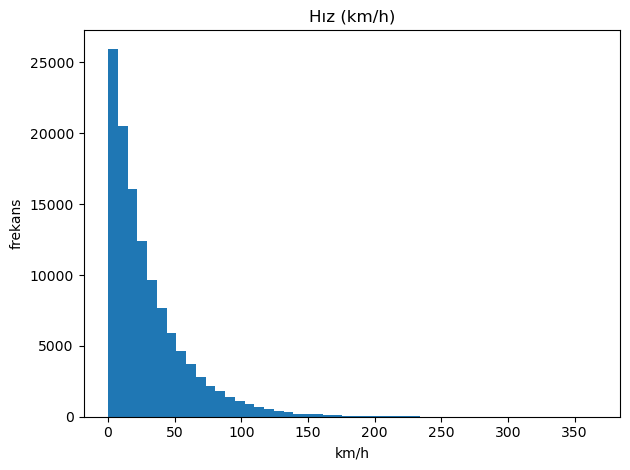

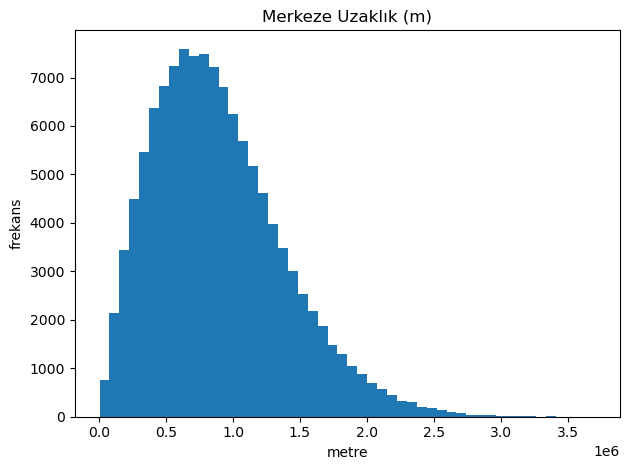

In [6]:
# --- Görseller
if "speed" in df.columns or "speed_kmh" in df.columns:
    v = (df["speed"]*3.6 if "speed" in df.columns else df["speed_kmh"]).astype(float)
    plt.figure()
    v.plot.hist(bins=50)
    plt.title("Hız (km/h)")
    plt.xlabel("km/h"); plt.ylabel("frekans")
    plt.tight_layout()
    plt.savefig(PLOTS / "speed_hist_kmh.png", dpi=160)
    plt.show()

plt.figure()
pd.Series(dist_m).plot.hist(bins=50)
plt.title("Merkeze Uzaklık (m)")
plt.xlabel("metre"); plt.ylabel("frekans")
plt.tight_layout()
plt.savefig(PLOTS / "distance_hist_m.png", dpi=160)
plt.show()


Üretilen bilgiler ne için kullanılabilir?
suggestions.json → configs/config.json içinde geofence.lat0, geofence.lon0, geofence.radius_m ve filters.max_speed_kmh değerlerini güncellerken doğrudan referans.
info_summary.json → veri kalitesi ve hız dağılımı bilgileri; filtre sınırlarını ve veri temizleme kurallarını belirlerken temel alınır.
missing_columns.json → mapping_dbra24.json dosyanı düzeltmek veya veri ön işleme script’ini revize etmek için rehber.
plots/* → rapor/dokümantasyon için görsel kanıt; gerekirse LLM’e vererek yönetici özeti ürettirebilirsin.